# Coinmetrics exploring
https://coinmetrics.io/community-network-data/

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import classification_report_generator as crg
from IPython.display import clear_output

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

from datetime import date, timedelta
import sys
sys.path.insert(0, '..')
import useful_functions as uf


In [284]:
df = pd.read_csv("../data/btc.csv") 
target =  pd.read_csv("../data/BTCUSDT-hour-target-features.csv")

In [285]:
len(df.columns)

140

In [286]:
df = df[-1385:]

In [287]:
df.date = pd.to_datetime(df.date)

In [288]:
for column in list(df.columns)[1:]:
    df[column] = uf.get_rate(df[column]) #Rate

# for column in list(df.columns)[1:]:
#     df[column] = list(map(lambda x, c: x/c, df[column], df.PriceUSD)) #Over close

In [289]:
df = df.set_index('date').resample('H').pad()

In [290]:
df.index = list(map(lambda x: x+timedelta(days=1), df.index))

In [291]:
df = df[4:1+df.index.get_loc(target.iloc[-1].timestamp)]

In [292]:
target.timestamp = pd.to_datetime(target.timestamp)
target = target.set_index('timestamp').resample('H').pad()

In [293]:
df = pd.concat([target, df], axis=1)

In [294]:
df.head(3)

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
columns = list(pd.read_csv("../data/btc.csv").columns[1:])
base_indicators = ['volume_nvi_o_close_rate_50',
 'mom_srsi_10_d',
 'bb',
 'volatility_dc_wband_10',
 'volatility_bb_pband_100',
 'volatility_bb_wband_200',
 'trend_trix_20_log',
 'trend_vi_50_amp',
 'mom_rsi_30',
 'volume_cmf_50_rate_200',
 'trend_sma_200_diff_o_close_log',
 'mom_ppo_30_hist',
 'trend_sma_50_diff_log',
 'target']

In [221]:
def test_all_features(paths:str, force_restart=False):
    """
    find weights
    """
    try:
        pd.read_csv(paths)
        if force_restart:
            raise ValueError('A very specific bad thing happened.')
    except:
        results = pd.DataFrame(columns=["f1", "precision", "recall", "corr", "importance", "feature"])
#         result = pd.Series([0., 0., 0., 0., "test"], index=list(results.columns))
#         results = results.append(result, ignore_index=True)
        results.to_csv(paths, index=False)

    for feature in columns:
        results = pd.read_csv(paths)

        indicators = base_indicators.copy()
        indicators.append(feature)
        
        print(f"feature: {feature}")
        
        ## Finding correlation
        corr_matrix = df[[feature, "target"]].copy().corr()
        corr = corr_matrix.target[feature]
        print(f"correlation: {corr}")

        d = df.copy()
        d.dropna(inplace=True)

        d = d[indicators].copy().astype(np.float32)

        X = d.drop(["target", "close"], axis=1, errors="ignore")[:30000]
        y = d["target"][:30000]

        model = RandomForestClassifier()
        f1 = np.mean(cross_val_score(model, X, y, cv=5, scoring="f1"))
        print(f"f1: {f1}")
        p = np.mean(cross_val_score(model, X, y, cv=5, scoring="precision"))
        print(f"precision: {p}")
        
        ## Feature importance
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        feature_dict = dict(zip(X_train.columns, list(model.feature_importances_)))
        feature_df = pd.DataFrame(feature_dict, index=[0])
        importance = feature_df.iloc[0][feature]
        print(f"feature importance: {importance}")
        
        print("DEBUG INFO:")
        print(f"indicators length:{len(indicators)}")
        print(f"indicators:{indicators}")

        r = np.mean(cross_val_score(model, X, y, cv=5, scoring="recall"))


        result = pd.Series([f1, p, r, corr, importance, feature], index=results.columns)
        results = results.append(result, ignore_index=True)
        results.to_csv(paths, index=False)
        clear_output()

In [222]:
test_all_features("../data/coinmetrics_o_close.csv", True)

In [235]:
df.to_csv("../data/BTCUSDT-hour-target-features-all-rate.csv", index=False)

In [295]:
columns = [
 'FlowTfrFromExCnt',
 'target']

In [296]:
d = df[columns].copy()
d["test"] = list(map(lambda x: uf.log_abs(x), df.FlowTfrFromExCnt))

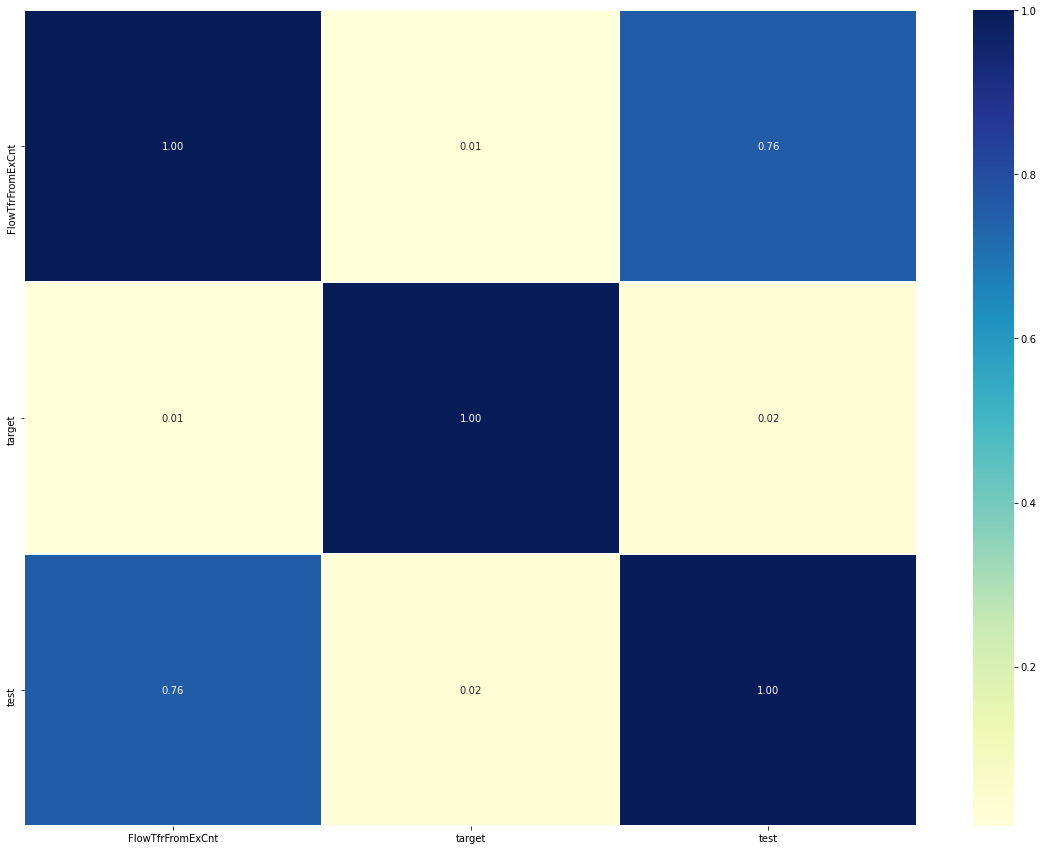

In [297]:
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

In [265]:
dplot = df[-2000:]

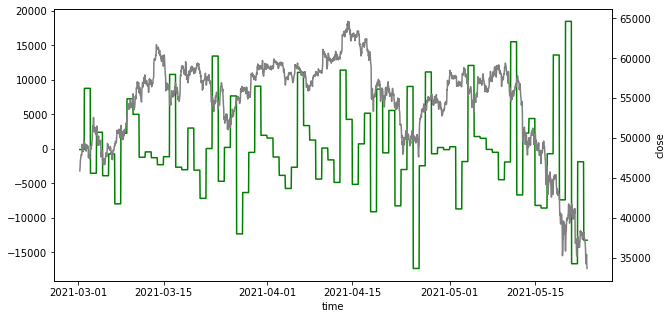

In [266]:
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(dplot.FlowTfrFromExCnt,
        color="green")
ax.set_xlabel("time")

ax2=ax.twinx()
ax2.plot(dplot.close,
     color="gray")

ax2.set_ylabel("close")
plt.show()


In [60]:
d = df[-1384:]
d = d[int(0.8*len(d)):]
close = close[int(0.8*len(close)):]

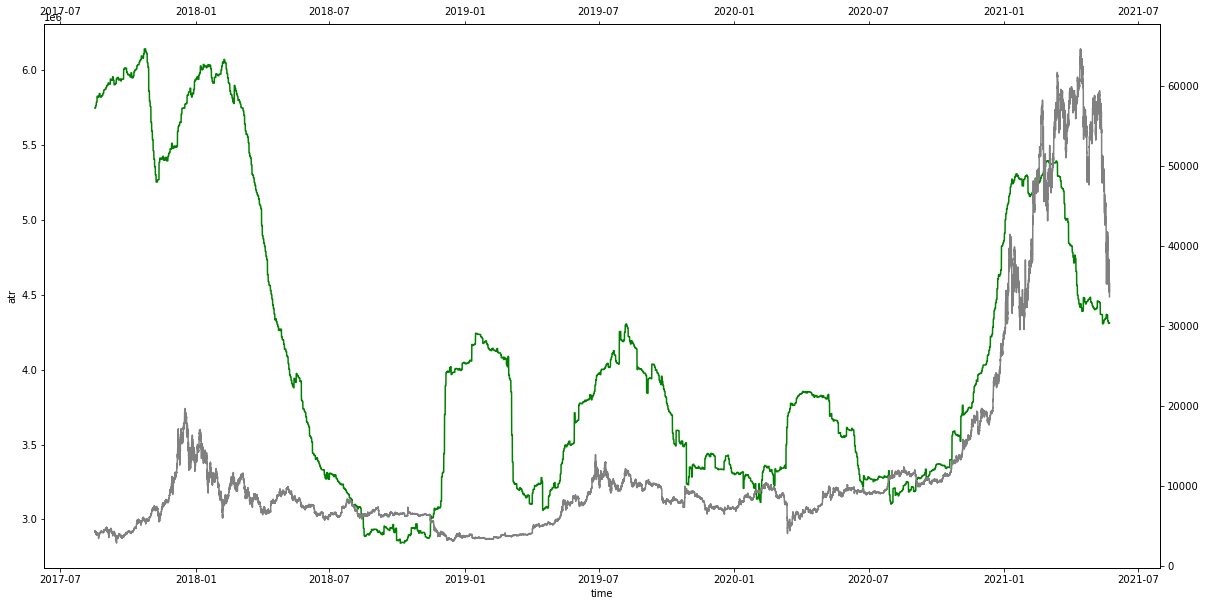

In [118]:
fig,ax = plt.subplots(figsize=(20, 10))
ax.plot(df.SplyAct90d,
        color="green")
ax.set_xlabel("time")
ax.set_ylabel("atr")

ax2=ax.twinx().twiny()
ax2.plot(df.close,
         color="gray")

# ax2.set_ylabel("close")
plt.show()